In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_palette("husl")

def add_technical_indicators(df):
    # Trend Indicators
    for window in [20, 50, 100]:
        df[f'MA_{window}'] = df['close'].rolling(window=window).mean()
        df[f'STD_{window}'] = df['close'].rolling(window=window).std()
    
    # Enhanced Momentum Indicators
    df['Returns'] = df['close'].pct_change()
    df['ROC_5'] = df['close'].pct_change(periods=5)
    df['ROC_21'] = df['close'].pct_change(periods=21)
    
    # Volume-Price Relationship
    df['Volume_MA20'] = df['volume'].rolling(window=20).mean()
    df['Volume_Price_Trend'] = (df['volume'] * df['Returns']).rolling(window=20).mean()
    
    # Enhanced RSI with multiple lookback periods
    for period in [14, 21]:
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df[f'RSI_{period}'] = 100 - (100 / (1 + rs))
    
    # Enhanced MACD
    exp12 = df['close'].ewm(span=12, adjust=False).mean()
    exp26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal_Line']
    
    # Volatility Indicators
    df['ATR'] = calculate_atr(df)
    
    return df

def calculate_atr(df, period=14):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift())
    tr3 = abs(df['low'] - df['close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def detect_market_regime(df):
    # Enhanced market regime detection
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    df['Trend_Strength'] = abs(df['MA_20'] - df['MA_50']) / df['MA_50'] * 100
    df['Volume_Trend'] = df['volume'].rolling(window=20).mean() / df['volume'].rolling(window=100).mean()
    
    # Market regime classification
    df['Market_Regime'] = 'Neutral'
    
    # Strong trend conditions
    strong_trend = (df['Trend_Strength'] > df['Trend_Strength'].quantile(0.8)) & \
                  (df['Volume_Trend'] > 1.2)
    df.loc[strong_trend, 'Market_Regime'] = 'Strong_Trend'
    
    # Ranging market conditions
    ranging = (df['Trend_Strength'] < df['Trend_Strength'].quantile(0.2)) & \
             (df['Volatility'] < df['Volatility'].quantile(0.5))
    df.loc[ranging, 'Market_Regime'] = 'Range'
    
    # High volatility conditions
    high_vol = df['Volatility'] > df['Volatility'].quantile(0.8)
    df.loc[high_vol, 'Market_Regime'] = 'High_Volatility'
    
    return df

def generate_signals(df):
    df['Signal'] = 0
    
    # Different signals for different market regimes
    for regime in df['Market_Regime'].unique():
        mask = df['Market_Regime'] == regime
        
        if regime == 'Strong_Trend':
            # Trend following signals
            df.loc[mask & (df['MACD'] > df['Signal_Line']) & 
                  (df['close'] > df['MA_50']) & 
                  (df['Volume_Price_Trend'] > 0), 'Signal'] = 1
            
            df.loc[mask & (df['MACD'] < df['Signal_Line']) & 
                  (df['close'] < df['MA_50']) & 
                  (df['Volume_Price_Trend'] < 0), 'Signal'] = -1
            
        elif regime == 'Range':
            # Mean reversion signals
            df.loc[mask & (df['RSI_14'] < 30) & 
                  (df['Volume_Trend'] > 1), 'Signal'] = 1
            
            df.loc[mask & (df['RSI_14'] > 70) & 
                  (df['Volume_Trend'] > 1), 'Signal'] = -1
            
        elif regime == 'High_Volatility':
            # More conservative signals with tighter stops
            df.loc[mask, 'Signal'] *= 0.5  # Reduce position size
    
    # Add stop-loss and take-profit logic
    df['Stop_Loss'] = df['close'] * 0.95  # 5% stop loss
    df['Take_Profit'] = df['close'] * 1.15  # 15% take profit
    
    return df

def backtest_strategy(df, initial_capital=100000):
    df['Position'] = df['Signal'].shift(1)
    df['Returns'] = df['close'].pct_change()
    
    # Apply stop-loss and take-profit
    for i in range(1, len(df)):
        if df['Position'].iloc[i] != 0:  # If we have a position
            entry_price = df['close'].iloc[i-1]
            stop_loss = entry_price * 0.95
            take_profit = entry_price * 1.15
            
            if df['low'].iloc[i] < stop_loss:  # Stop-loss hit
                df.loc[df.index[i], 'Returns'] = (stop_loss - entry_price) / entry_price
                df.loc[df.index[i], 'Position'] = 0
            elif df['high'].iloc[i] > take_profit:  # Take-profit hit
                df.loc[df.index[i], 'Returns'] = (take_profit - entry_price) / entry_price
                df.loc[df.index[i], 'Position'] = 0
    
    df['Strategy_Returns'] = df['Position'] * df['Returns']
    df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns']).cumprod()
    
    # Calculate improved metrics
    total_return = (df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
    sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()
    max_drawdown = (df['Portfolio_Value'] / df['Portfolio_Value'].cummax() - 1).min() * 100
    win_rate = len(df[df['Strategy_Returns'] > 0]) / len(df[df['Strategy_Returns'] != 0]) * 100
    
    return {
        'Total Return (%)': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Win Rate (%)': win_rate,
        'Risk-Adjusted Return': total_return / abs(max_drawdown)
    }

def plot_analysis(df):
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    
    # Price and Moving Averages
    axes[0].plot(df.index, df['close'], label='Price')
    axes[0].plot(df.index, df['MA_20'], label='20-day MA')
    axes[0].plot(df.index, df['MA_50'], label='50-day MA')
    axes[0].set_title('Price and Moving Averages')
    axes[0].legend()
    
    # Market Regime
    regime_colors = {'Strong_Trend': 'g', 'Range': 'b', 'High_Volatility': 'r', 'Neutral': 'gray'}
    for regime in regime_colors:
        mask = df['Market_Regime'] == regime
        axes[1].scatter(df[mask].index, df[mask]['close'], 
                       c=regime_colors[regime], label=regime, alpha=0.5)
    axes[1].set_title('Market Regimes')
    axes[1].legend()
    
    # Signals and Returns
    axes[2].scatter(df[df['Signal'] == 1].index, 
                   df[df['Signal'] == 1]['close'], 
                   c='g', marker='^', label='Buy')
    axes[2].scatter(df[df['Signal'] == -1].index, 
                   df[df['Signal'] == -1]['close'], 
                   c='r', marker='v', label='Sell')
    axes[2].plot(df.index, df['close'], alpha=0.5)
    axes[2].set_title('Trading Signals')
    axes[2].legend()
    
    # Portfolio Performance
    axes[3].plot(df.index, df['Portfolio_Value'])
    axes[3].set_title('Portfolio Value Over Time')
    
    plt.tight_layout()
    plt.show()


In [7]:

# Example usage
def main():
    df = pd.read_csv('btc_binance_data.csv')
    df['Date'] = pd.to_datetime(df['timestamp'] if 'timestamp' in df.columns else df.index)
    df.set_index('Date', inplace=True)
    df = add_technical_indicators(df)
    df = detect_market_regime(df)
    df = generate_signals(df)
    results = backtest_strategy(df)
    plot_analysis(df)
    
    print("\nStrategy Performance Metrics:")
    for metric, value in results.items():
        print(f"{metric}: {value:.2f}")

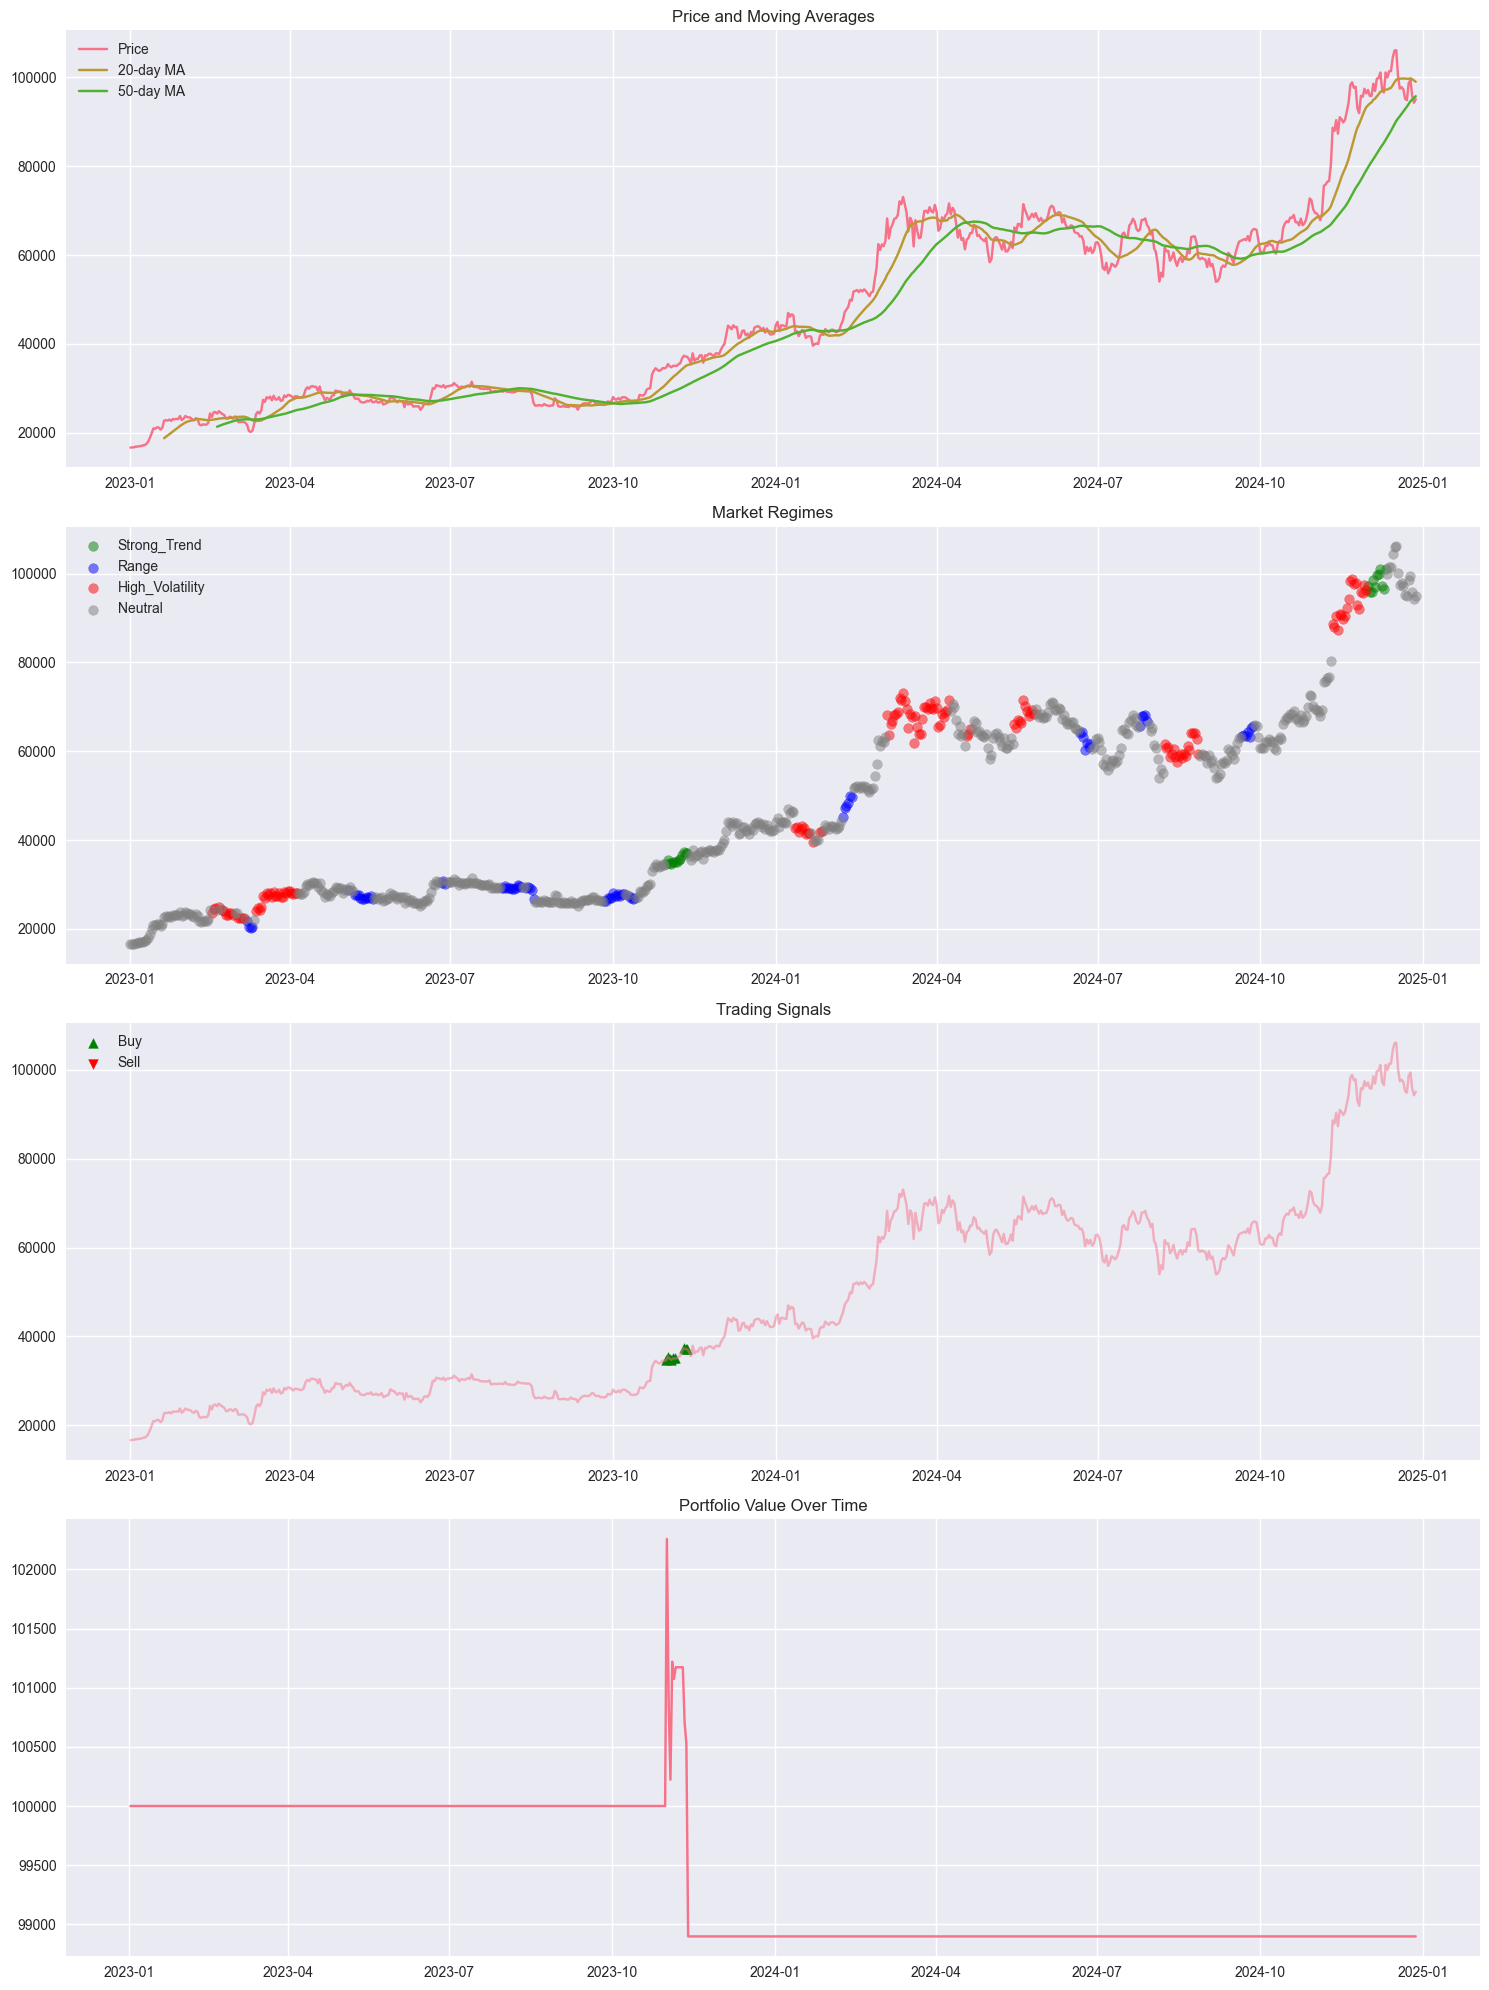


Strategy Performance Metrics:
Total Return (%): -1.10
Sharpe Ratio: -0.18
Max Drawdown (%): -3.28
Win Rate (%): 30.00
Risk-Adjusted Return: -0.34


In [8]:
if __name__ == "__main__":
    main()

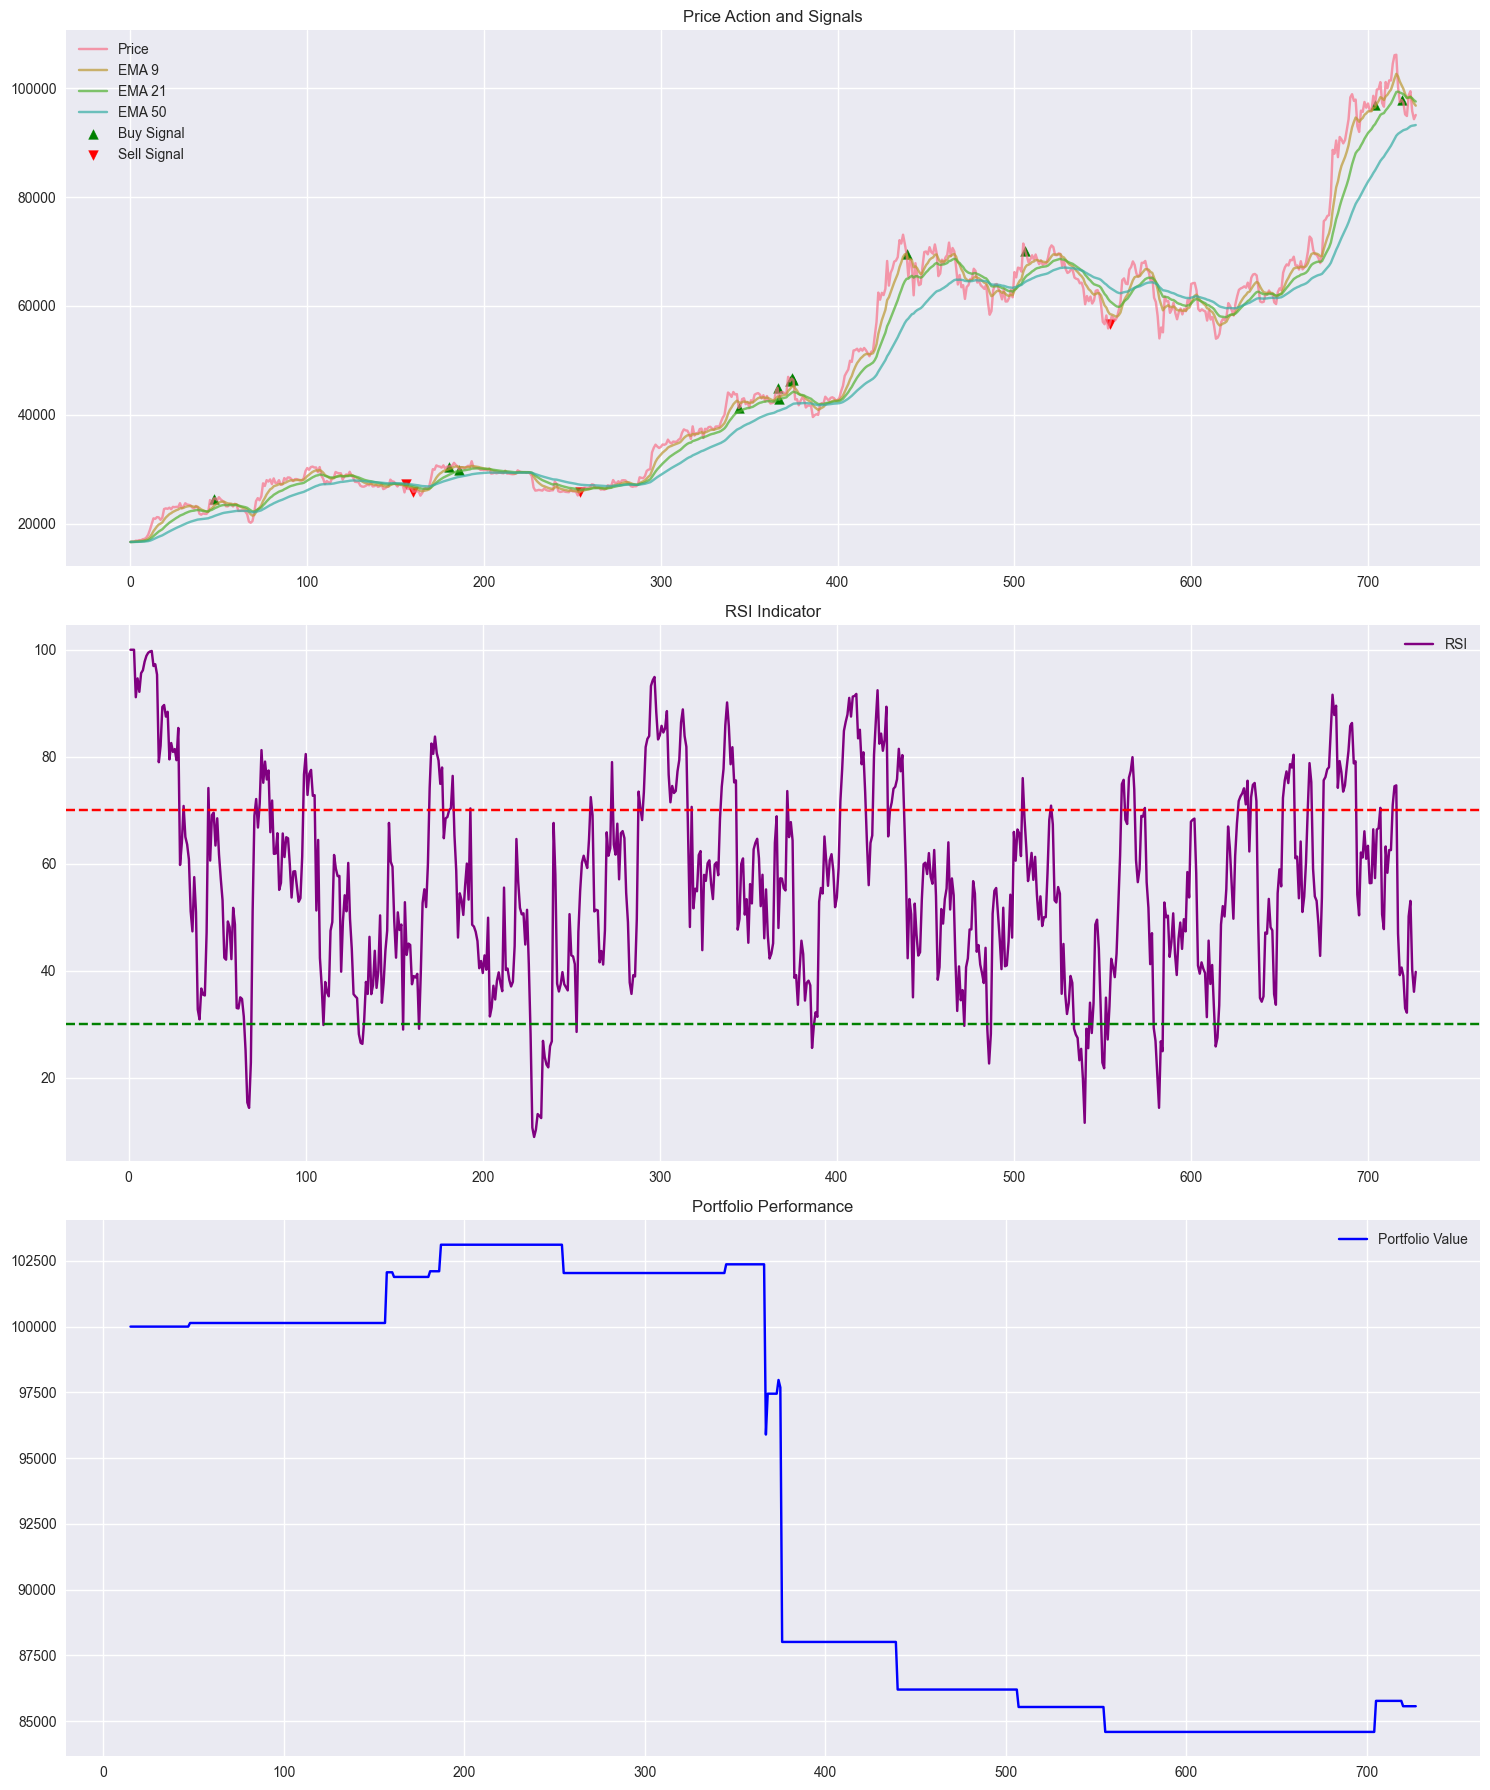


Strategy Performance Metrics:
Total Return (%): -14.43
Sharpe Ratio: -0.71
Max Drawdown (%): -17.96
Win Rate (%): 25.00
Profit Factor: 0.33


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

def add_technical_indicators(df):
    # Price Action
    df['high_low_diff'] = df['high'] - df['low']
    df['close_open_diff'] = df['close'] - df['open']
    
    # Triple EMA Strategy
    df['EMA_9'] = df['close'].ewm(span=9, adjust=False).mean()
    df['EMA_21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    
    # Volume Analysis
    df['Volume_EMA'] = df['volume'].ewm(span=20, adjust=False).mean()
    df['Volume_Ratio'] = df['volume'] / df['Volume_EMA']
    
    # Advanced RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=14, adjust=False).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # True Range for volatility
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift()),
            abs(df['low'] - df['close'].shift())
        )
    )
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    return df

def generate_signals(df):
    df['Signal'] = 0
    
    # Entry conditions
    long_condition = (
        (df['EMA_9'] > df['EMA_21']) &  # Short-term trend up
        (df['EMA_21'] > df['EMA_50']) &  # Medium-term trend up
        (df['Volume_Ratio'] > 1.5) &      # Strong volume
        (df['RSI'] > 40) &                # Not oversold
        (df['RSI'] < 70)                  # Not overbought
    )
    
    short_condition = (
        (df['EMA_9'] < df['EMA_21']) &   # Short-term trend down
        (df['EMA_21'] < df['EMA_50']) &  # Medium-term trend down
        (df['Volume_Ratio'] > 1.5) &      # Strong volume
        (df['RSI'] > 30) &                # Not oversold
        (df['RSI'] < 60)                  # Not overbought
    )
    
    df.loc[long_condition, 'Signal'] = 1
    df.loc[short_condition, 'Signal'] = -1
    
    # Risk Management: No trading in high volatility
    high_volatility = df['ATR'] > df['ATR'].rolling(window=20).mean() * 1.5
    df.loc[high_volatility, 'Signal'] = 0
    
    return df

def apply_risk_management(df):
    position_size = 0.02  # 2% risk per trade
    
    # Calculate position size based on ATR
    df['Position_Size'] = position_size / (df['ATR'] / df['close'])
    
    # Apply trailing stop loss
    df['Trail_Stop'] = np.nan
    
    for i in range(1, len(df)):
        if df['Signal'].iloc[i] != 0:
            # Set initial stop loss at 2 ATR
            stop_distance = 2 * df['ATR'].iloc[i]
            
            if df['Signal'].iloc[i] == 1:  # Long position
                df.loc[df.index[i], 'Trail_Stop'] = df['close'].iloc[i] - stop_distance
            else:  # Short position
                df.loc[df.index[i], 'Trail_Stop'] = df['close'].iloc[i] + stop_distance
                
    return df

def backtest_strategy(df, initial_capital=100000):
    df['Position'] = df['Signal'] * df['Position_Size']
    df['Returns'] = df['close'].pct_change()
    df['Strategy_Returns'] = df['Position'].shift(1) * df['Returns']
    
    # Apply stop losses
    for i in range(1, len(df)):
        if df['Position'].iloc[i-1] != 0:  # If we had a position
            if df['Position'].iloc[i-1] > 0:  # Long position
                if df['low'].iloc[i] < df['Trail_Stop'].iloc[i-1]:
                    df.loc[df.index[i], 'Strategy_Returns'] = \
                        (df['Trail_Stop'].iloc[i-1] - df['close'].iloc[i-1]) / df['close'].iloc[i-1]
                    df.loc[df.index[i], 'Position'] = 0
            else:  # Short position
                if df['high'].iloc[i] > df['Trail_Stop'].iloc[i-1]:
                    df.loc[df.index[i], 'Strategy_Returns'] = \
                        (df['close'].iloc[i-1] - df['Trail_Stop'].iloc[i-1]) / df['close'].iloc[i-1]
                    df.loc[df.index[i], 'Position'] = 0
    
    df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns']).cumprod()
    
    # Calculate metrics
    total_return = (df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
    sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()
    max_drawdown = (df['Portfolio_Value'] / df['Portfolio_Value'].cummax() - 1).min() * 100
    win_rate = len(df[df['Strategy_Returns'] > 0]) / len(df[df['Strategy_Returns'] != 0]) * 100
    profit_factor = abs(df[df['Strategy_Returns'] > 0]['Strategy_Returns'].sum() / 
                       df[df['Strategy_Returns'] < 0]['Strategy_Returns'].sum())
    
    return {
        'Total Return (%)': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor
    }

def plot_analysis(df):
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    
    # Price and EMAs
    axes[0].plot(df.index, df['close'], label='Price', alpha=0.7)
    axes[0].plot(df.index, df['EMA_9'], label='EMA 9', alpha=0.7)
    axes[0].plot(df.index, df['EMA_21'], label='EMA 21', alpha=0.7)
    axes[0].plot(df.index, df['EMA_50'], label='EMA 50', alpha=0.7)
    axes[0].scatter(df[df['Signal'] == 1].index, 
                   df[df['Signal'] == 1]['close'],
                   marker='^', color='g', label='Buy Signal')
    axes[0].scatter(df[df['Signal'] == -1].index,
                   df[df['Signal'] == -1]['close'],
                   marker='v', color='r', label='Sell Signal')
    axes[0].set_title('Price Action and Signals')
    axes[0].legend()
    
    # RSI
    axes[1].plot(df.index, df['RSI'], label='RSI', color='purple')
    axes[1].axhline(y=70, color='r', linestyle='--')
    axes[1].axhline(y=30, color='g', linestyle='--')
    axes[1].set_title('RSI Indicator')
    axes[1].legend()
    
    # Portfolio Value
    axes[2].plot(df.index, df['Portfolio_Value'], label='Portfolio Value', color='blue')
    axes[2].set_title('Portfolio Performance')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

df = pd.read_csv('btc_binance_data.csv')
# Run the strategy
df = add_technical_indicators(df)
df = generate_signals(df)
df = apply_risk_management(df)
results = backtest_strategy(df)

# Plot results
plot_analysis(df)

print("\nStrategy Performance Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.2f}")

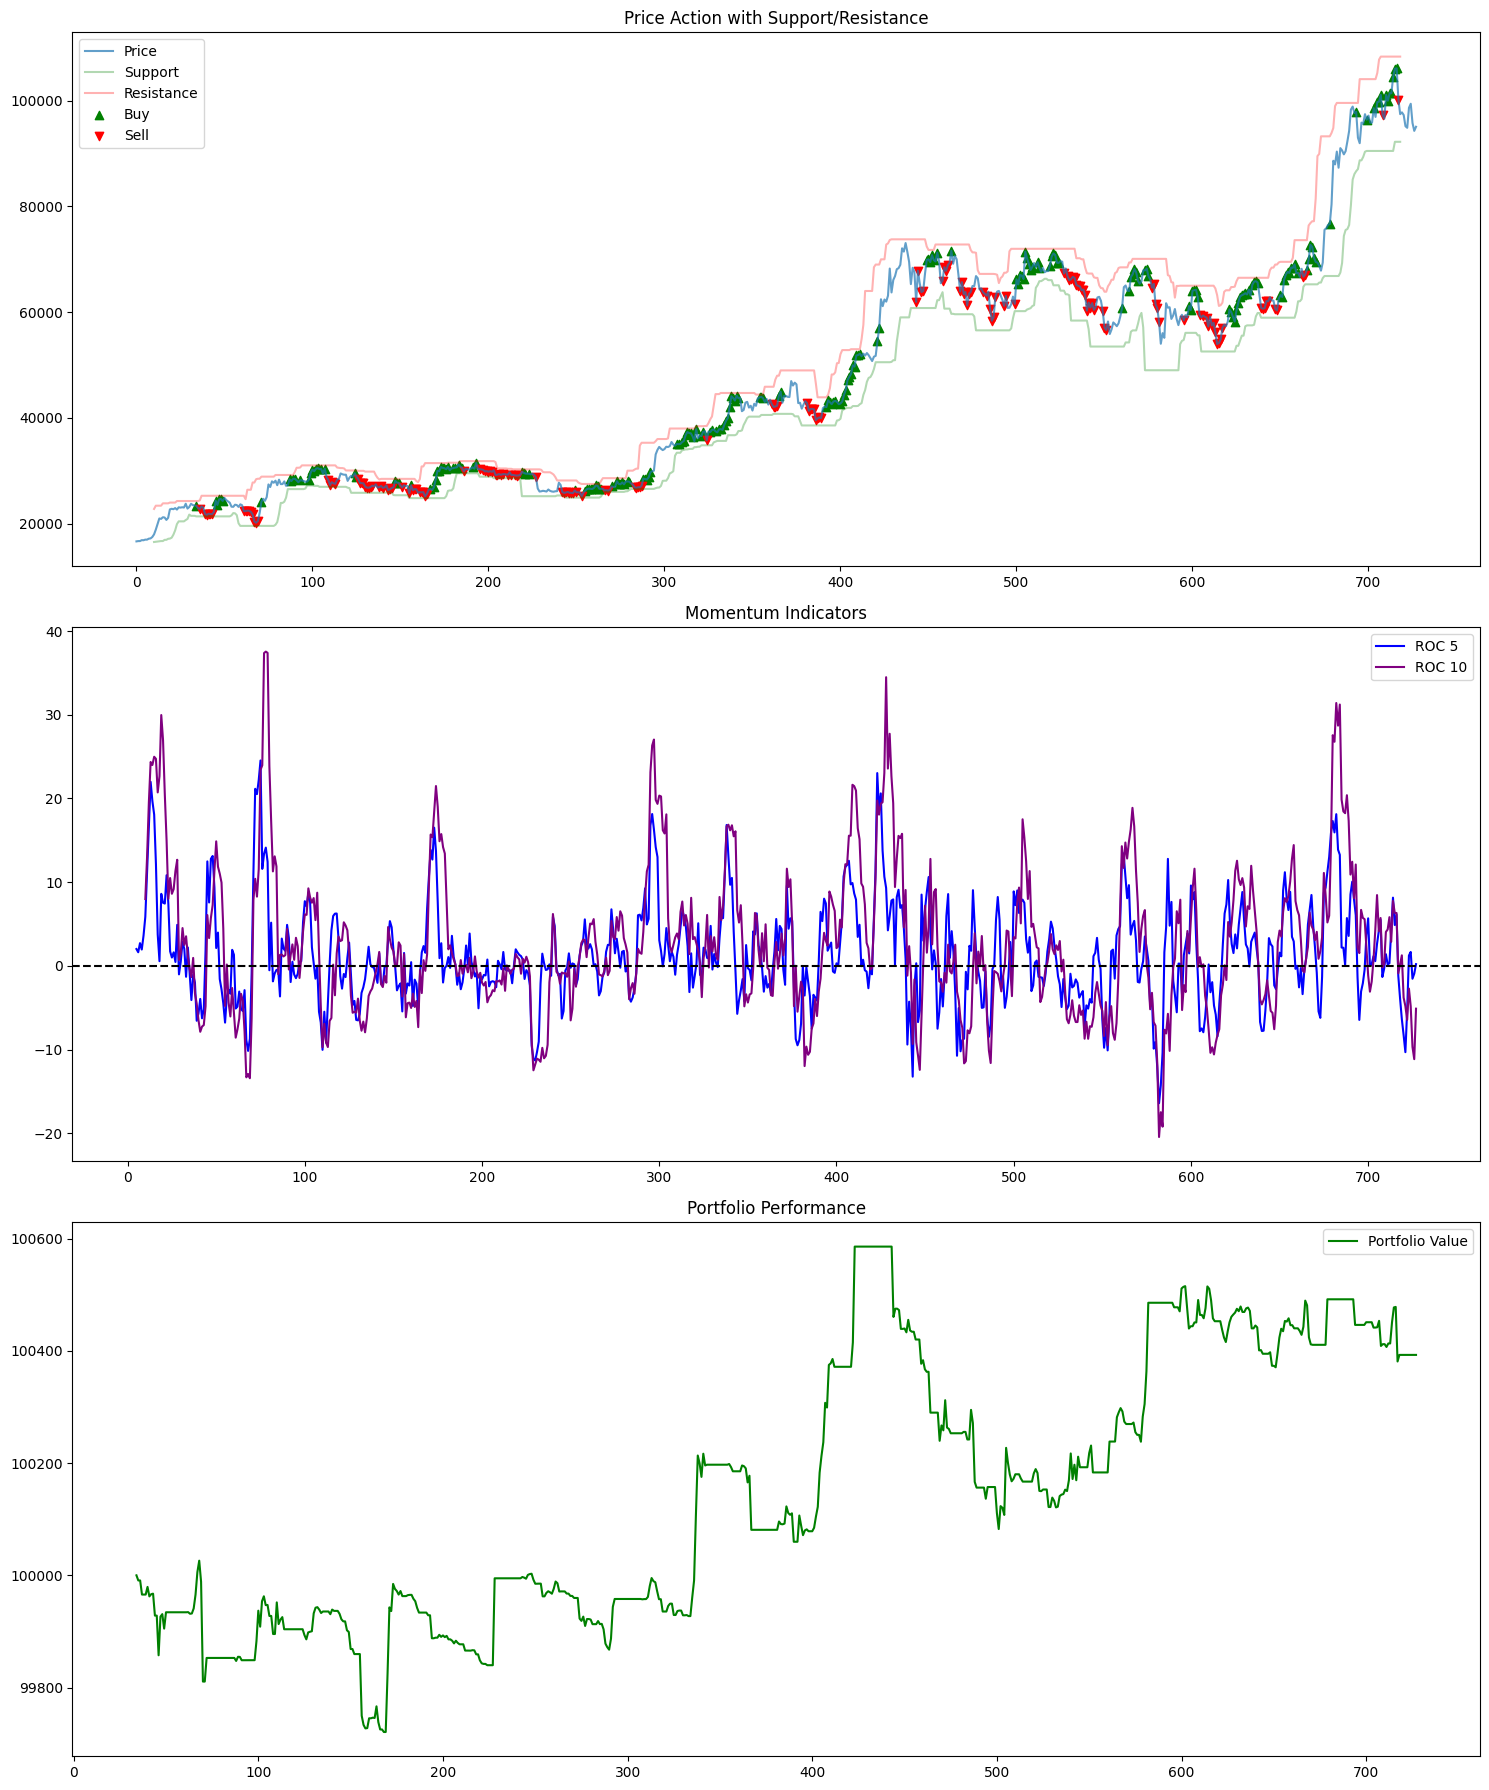


Strategy Performance Metrics:
Total Return (%): 0.39
Sharpe Ratio: 0.38
Max Drawdown (%): -0.50
Win Rate (%): 42.93
Profit Factor: 1.27
Avg Win (%): 0.02
Avg Loss (%): -0.02


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def identify_key_levels(df, window=20):
    """Identify support and resistance levels using fractal method"""
    df['Resistance'] = df['high'].rolling(window=window, center=True).max()
    df['Support'] = df['low'].rolling(window=window, center=True).min()
    
    # Identify strong levels using volume
    df['Volume_MA'] = df['volume'].rolling(window=window).mean()
    high_volume = df['volume'] > df['Volume_MA'] * 1.5
    
    df['Strong_Resistance'] = np.where(high_volume, df['Resistance'], np.nan)
    df['Strong_Support'] = np.where(high_volume, df['Support'], np.nan)
    
    return df

def add_momentum_indicators(df):
    """Calculate momentum-based indicators"""
    # Rate of Change
    df['ROC_5'] = df['close'].pct_change(periods=5) * 100
    df['ROC_10'] = df['close'].pct_change(periods=10) * 100
    
    # Momentum
    df['Momentum'] = df['close'] - df['close'].shift(10)
    
    # Average True Range for volatility
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift()),
            abs(df['low'] - df['close'].shift())
        )
    )
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    # Volume Force Index
    df['Force_Index'] = df['close'].diff() * df['volume']
    df['Force_Index_EMA'] = df['Force_Index'].ewm(span=13, adjust=False).mean()
    
    return df

def generate_signals(df):
    df['Signal'] = 0
    
    # Long conditions
    long_setup = (
        (df['close'] > df['Support']) &  # Price above support
        (df['ROC_5'] > 0) &              # Short-term momentum positive
        (df['ROC_10'] > 0) &             # Medium-term momentum positive
        (df['Force_Index_EMA'] > 0)      # Strong buying pressure
    )
    
    # Short conditions
    short_setup = (
        (df['close'] < df['Resistance']) &  # Price below resistance
        (df['ROC_5'] < 0) &                 # Short-term momentum negative
        (df['ROC_10'] < 0) &                # Medium-term momentum negative
        (df['Force_Index_EMA'] < 0)         # Strong selling pressure
    )
    
    # Only trade if volatility is reasonable
    normal_volatility = df['ATR'] <= df['ATR'].rolling(window=20).mean() * 1.2
    
    # Apply signals
    df.loc[long_setup & normal_volatility, 'Signal'] = 1
    df.loc[short_setup & normal_volatility, 'Signal'] = -1
    
    return df

def apply_position_sizing(df):
    """Dynamic position sizing based on volatility and momentum strength"""
    # Base position size (1% risk per trade)
    base_size = 0.01
    
    # Adjust size based on momentum strength
    momentum_factor = abs(df['ROC_5']) / df['ROC_5'].rolling(window=20).std()
    momentum_factor = momentum_factor.clip(0.5, 2.0)  # Limit adjustment range
    
    # Adjust size based on volatility
    volatility_factor = df['ATR'].rolling(window=20).mean() / df['ATR']
    volatility_factor = volatility_factor.clip(0.5, 1.5)
    
    df['Position_Size'] = base_size * momentum_factor * volatility_factor
    return df

def backtest_strategy(df, initial_capital=100000):
    df['Position'] = df['Signal'] * df['Position_Size']
    df['Returns'] = df['close'].pct_change()
    df['Strategy_Returns'] = df['Position'].shift(1) * df['Returns']
    
    # Implement stop-loss
    stop_loss = -0.02  # 2% stop loss
    take_profit = 0.04  # 4% take profit
    
    for i in range(1, len(df)):
        if df['Position'].iloc[i-1] != 0:  # If we had a position
            daily_return = df['Returns'].iloc[i]
            
            # Check if stop loss or take profit hit
            if df['Position'].iloc[i-1] > 0:  # Long position
                if daily_return <= stop_loss or daily_return >= take_profit:
                    df.loc[df.index[i], 'Position'] = 0
            else:  # Short position
                if daily_return >= -stop_loss or daily_return <= -take_profit:
                    df.loc[df.index[i], 'Position'] = 0
    
    df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns']).cumprod()
    
    # Calculate metrics
    total_return = (df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
    sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()
    max_drawdown = (df['Portfolio_Value'] / df['Portfolio_Value'].cummax() - 1).min() * 100
    win_rate = len(df[df['Strategy_Returns'] > 0]) / len(df[df['Strategy_Returns'] != 0]) * 100
    avg_win = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].mean()
    avg_loss = df[df['Strategy_Returns'] < 0]['Strategy_Returns'].mean()
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    
    return {
        'Total Return (%)': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Avg Win (%)': avg_win * 100,
        'Avg Loss (%)': avg_loss * 100
    }

def plot_analysis(df):
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    
    # Price with Support/Resistance
    axes[0].plot(df.index, df['close'], label='Price', alpha=0.7)
    axes[0].plot(df.index, df['Support'], label='Support', alpha=0.3, color='g')
    axes[0].plot(df.index, df['Resistance'], label='Resistance', alpha=0.3, color='r')
    axes[0].scatter(df[df['Signal'] == 1].index, 
                   df[df['Signal'] == 1]['close'],
                   marker='^', color='g', label='Buy')
    axes[0].scatter(df[df['Signal'] == -1].index,
                   df[df['Signal'] == -1]['close'],
                   marker='v', color='r', label='Sell')
    axes[0].set_title('Price Action with Support/Resistance')
    axes[0].legend()
    
    # Momentum
    axes[1].plot(df.index, df['ROC_5'], label='ROC 5', color='blue')
    axes[1].plot(df.index, df['ROC_10'], label='ROC 10', color='purple')
    axes[1].axhline(y=0, color='black', linestyle='--')
    axes[1].set_title('Momentum Indicators')
    axes[1].legend()
    
    # Portfolio Value
    axes[2].plot(df.index, df['Portfolio_Value'], label='Portfolio Value', color='green')
    axes[2].set_title('Portfolio Performance')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
df = pd.read_csv('btc_binance_data.csv')
# Run strategy
df = identify_key_levels(df)
df = add_momentum_indicators(df)
df = generate_signals(df)
df = apply_position_sizing(df)
results = backtest_strategy(df)

# Plot results
plot_analysis(df)

print("\nStrategy Performance Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.2f}")